<a href="https://colab.research.google.com/github/andrecamara2004/andrecamara2004.github.io/blob/main/Lab03h_Decoders_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Self-Attention vs Cross-Attention in Decoders

This exercise demonstrates the difference between self-attention and cross-attention using pure PyTorch. Self-attention involves attending to tokens in the same sequence, while cross-attention allows the decoder to attend to the encoder's hidden states.
python
Copy
Edit


This function computes scaled dot-product attention by calculating attention scores, applying softmax to normalize them, and then multiplying the scores by the value vectors.

In [16]:
import torch
import torch.nn.functional as F


# Define a simple attention mechanism
def attention(query, key, value):
    # Scaled dot-product attention
    scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(key.size(-1), dtype=torch.float32))
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, value)
    return output, attn_weights

In [17]:
# Example input sequences
encoder_output = torch.randn(5, 64)  # Encoder output (batch_size=1, seq_len=5, hidden_dim=64)
decoder_input = torch.randn(4, 64)  # Decoder input (batch_size=1, seq_len=4, hidden_dim=64)


query_weights = torch.nn.Linear(64, 64)
key_weights = torch.nn.Linear(64, 64)
value_weights = torch.nn.Linear(64, 64)

# Self-attention in the decoder
#TODO Assign Inputs to the query,keys,vectors
query = query_weights(decoder_input)
key = key_weights(decoder_input)
value = value_weights(decoder_input)
self_attention_output, self_attention_weights = attention(query, key, value)

# Cross-attention (decoder attends to encoder)
#TODO Assign Inputs to the query,keys,vectors
query = query_weights(decoder_input)
key = key_weights(encoder_output)
value = value_weights(encoder_output)
cross_attention_output, cross_attention_weights = attention(query, key, value)

In [18]:
print("Self-Attention Weights Shape:",
      self_attention_weights.shape)  # Shape: [decoder_seq_len, decoder_seq_len]
print("Cross-Attention Weights Shape:",
      cross_attention_weights.shape)  # Shape: [decoder_seq_len, encoder_seq_len]


Self-Attention Weights Shape: torch.Size([4, 4])
Cross-Attention Weights Shape: torch.Size([4, 5])


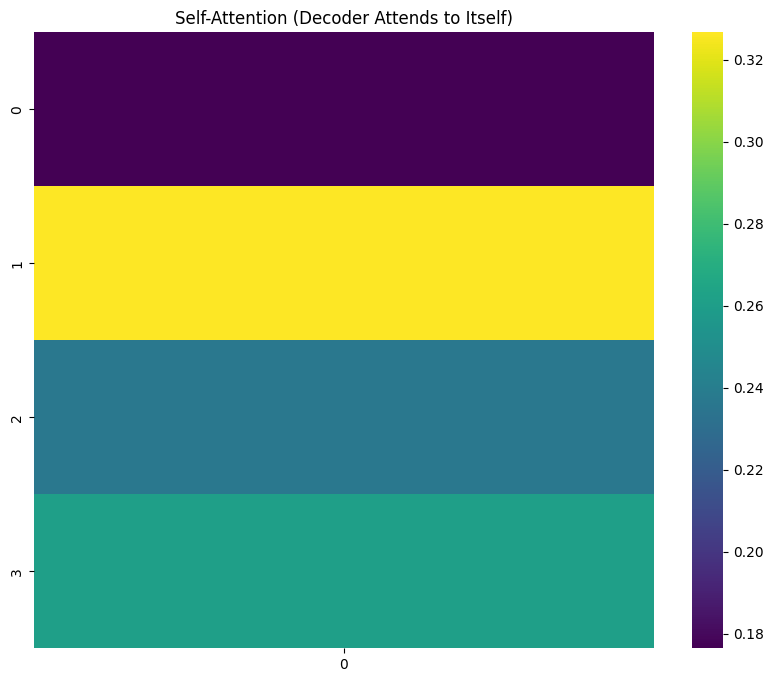

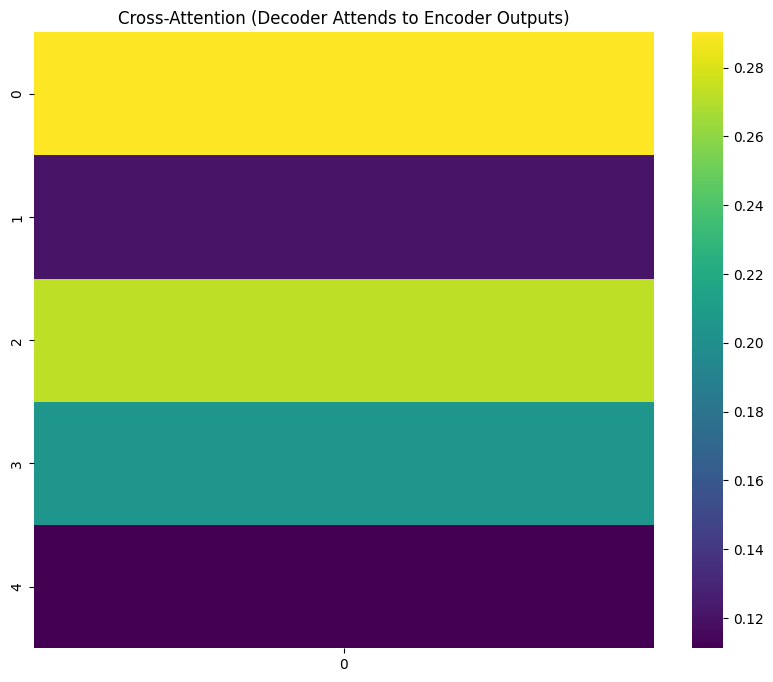

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Self-Attention
self_attention_data = self_attention_weights[0].detach().numpy()
# print("Self-Attention Shape:", self_attention_data.shape)  # Debugging

# Ensure 2D shape
if self_attention_data.ndim == 1:
    self_attention_data = self_attention_data.reshape(-1, 1)

plt.figure(figsize=(10, 8))
sns.heatmap(self_attention_data, cmap="viridis")
plt.title("Self-Attention (Decoder Attends to Itself)")
plt.show()

# Visualize Cross-Attention
cross_attention_data = cross_attention_weights[0].detach().numpy()
# print("Cross-Attention Shape:", cross_attention_data.shape)  # Debugging

# Ensure 2D shape
if cross_attention_data.ndim == 1:
    cross_attention_data = cross_attention_data.reshape(-1, 1)

plt.figure(figsize=(10, 8))
sns.heatmap(cross_attention_data, cmap="viridis")
plt.title("Cross-Attention (Decoder Attends to Encoder Outputs)")
plt.show()

## Masked Attention in Decoders
In this exercise, you'll manually compute masked attention in a decoder, where each token can only attend to previous tokens, simulating the autoregressive behavior of a language model.


This function implements masked scaled dot-product attention.
We first compute the attention scores, apply a mask to prevent attending to future tokens, and then apply softmax.

In [20]:
import torch
import torch.nn.functional as F


# Define masked attention mechanism
def masked_attention(query, key, value, mask):
    scores = torch.matmul(query, key.T) / torch.sqrt(torch.tensor(key.size(-1), dtype=torch.float32))

    # Apply the mask (set scores of future tokens to a very negative value)
    scores = scores.masked_fill(mask == 0, float('-inf'))

    # Apply softmax and compute attention output
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, value)
    return output, attn_weights

We create a lower triangular mask using `torch.tril()` to prevent future tokens from being attended to.
The mask ensures that the model can only attend to tokens before or at the current position.

In [21]:
# Example decoder input
decoder_input = torch.randn(6, 64)  # (batch_size=1, seq_len=6, hidden_dim=64)

query_weights = torch.nn.Linear(64, 64)
key_weights = torch.nn.Linear(64, 64)
value_weights = torch.nn.Linear(64, 64)


# Create a triangular mask for autoregressive behavior
mask = torch.tril(torch.ones(decoder_input.shape[0], decoder_input.shape[0]))  # Lower triangular matrix

# Expand mask to match batch size and number of attention heads (assuming 1 head here)
mask = mask.unsqueeze(0)

# Compute masked attention
query = query_weights(decoder_input)
key = key_weights(decoder_input)
value = value_weights(decoder_input)
masked_attention_output, masked_attention_weights = masked_attention(query, key, value, mask)

In [22]:
torch.set_printoptions(linewidth=200)
print("Masked Attention Weights Shape:", masked_attention_weights.shape)
print("Masked Attention Weights Shape:\n", masked_attention_weights)

Masked Attention Weights Shape: torch.Size([1, 6, 6])
Masked Attention Weights Shape:
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4005, 0.5995, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2676, 0.6118, 0.1206, 0.0000, 0.0000, 0.0000],
         [0.1267, 0.3294, 0.3727, 0.1712, 0.0000, 0.0000],
         [0.2509, 0.2233, 0.2018, 0.1616, 0.1624, 0.0000],
         [0.1569, 0.1696, 0.1659, 0.1042, 0.2309, 0.1725]]], grad_fn=<SoftmaxBackward0>)


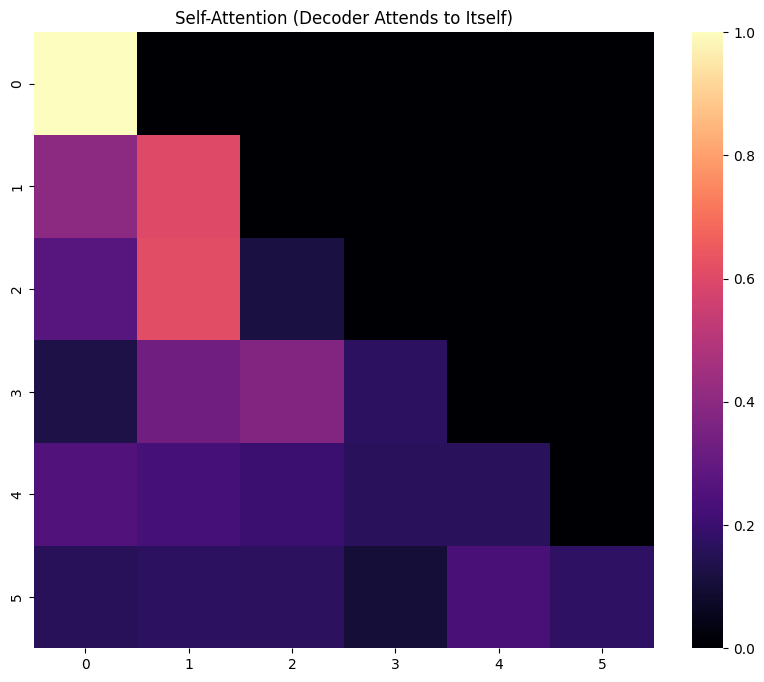

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Masked Self-Attention
plt.figure(figsize=(10, 8))
sns.heatmap(masked_attention_weights[0].detach().numpy(), cmap="magma")
plt.title("Self-Attention (Decoder Attends to Itself)")
plt.show()

